# Using `redflag` with `sklearn`

As well as using `redflag`'s functions directly (see `Basic_usage.ipynb`), `redflag` has some `sklearn` transformers that you can use to detect possible issues in your data. 

⚠️ **Note that these transformers do not transform your data, they only raise warnings (red flags) if they find issues.**

Let's load some example data:

In [1]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_training_data.csv')
df.head()

,Well Name,Depth,Formation,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Facies,LATITUDE,LONGITUDE,ILD_log10,Lithology,RHOB,Mineralogy,Siliciclastic
0,SHRIMPLIN,851.3064,A1 SH,1.000,1,77.45,4.613176,9.9,11.915,4.6,3.0,37.978076,-100.987305,0.664,siltstone,2393.499945,siliciclastic,True
1,SHRIMPLIN,851.4588,A1 SH,0.979,1,78.26,4.581419,14.2,12.565,4.1,3.0,37.978076,-100.987305,0.661,siltstone,2416.119814,siliciclastic,True
2,SHRIMPLIN,851.6112,A1 SH,0.957,1,79.05,4.549881,14.8,13.050,3.6,3.0,37.978076,-100.987305,0.658,siltstone,2404.576056,siliciclastic,True
3,SHRIMPLIN,851.7636,A1 SH,0.936,1,86.10,4.518559,13.9,13.115,3.5,3.0,37.978076,-100.987305,0.655,siltstone,2393.249071,siliciclastic,True
4,SHRIMPLIN,851.9160,A1 SH,0.915,1,74.58,4.436086,13.5,13.300,3.4,3.0,37.978076,-100.987305,0.647,siltstone,2382.602601,siliciclastic,True


Note that the features (e.g. GR, RHOB) are not **independent** records; they are correlated to themselves in depth.

Furthermore, some of these features are clipped, e.g. the GR feature is clipped at a max value of 200:

<AxesSubplot:xlabel='GR', ylabel='Count'>

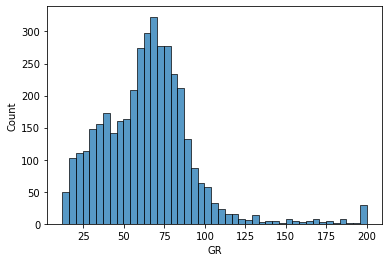

In [2]:
import seaborn as sns

sns.histplot(df['GR'])

We will split this dataset by group (well name):

In [3]:
features = ['GR', 'RHOB', 'PE']

test_wells = ['CRAWFORD', 'STUART']

test_flag = df['Well Name'].isin(test_wells)

X_test = df.loc[test_flag, features].values
y_test = df.loc[test_flag, 'Lithology'].values

X_train = df.loc[~test_flag, features].values
y_train = df.loc[~test_flag, 'Lithology'].values

## Using the `redflag` pipeline

There is a [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) you can use, containing all of the detectors. (At the time of writing, there are three components, but this is set to grow.)

In [4]:
import redflag as rf

rf.pipeline

Pipeline(steps=[('rf.clip', ClipDetector()), ('rf.outlier', OutlierDetector()),
                ('rf.corr', CorrelationDetector()),
                ('rf.dist', DistributionComparator())])

We can use this in another pipeline:

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe = make_pipeline(StandardScaler(), rf.pipeline, SVC())
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('rf.clip', ClipDetector()),
                                 ('rf.outlier', OutlierDetector()),
                                 ('rf.corr', CorrelationDetector()),
                                 ('rf.dist', DistributionComparator())])),
                ('svc', SVC())])

During the `fit` phase, the `redflag` transformers do two things:

- Check the input features for issues like clipping.
- Learn statistics of the input features for later comparison.

In [6]:
pipe.fit(X_train, y_train)

🚩 Features 0, 1 may have clipped values.
🚩 There are more outliers than expected in the training data (349 vs 31).
🚩 Features 0, 1, 2 may have correlated values.


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pipeline',
                 Pipeline(steps=[('rf.clip', ClipDetector()),
                                 ('rf.outlier',
                                  OutlierDetector(threshold=3.3682141715600706)),
                                 ('rf.corr', CorrelationDetector()),
                                 ('rf.dist', DistributionComparator())])),
                ('svc', SVC())])

When we pass in data for prediction, `redflag` checks the new inputs. Again, there are two parts:

- Check for first-order issues, e.g. for clipping.
- Compare statistics to the training data, e.g. to compare the distribution of the data (we want it to be the same as the training data).

In [7]:
pipe.predict(X_test)

🚩 Feature 0 may have clipped values.
🚩 There are more outliers than expected in the data (30 vs 8).
🚩 Features 0, 1, 2 may have correlated values.
🚩 Feature 2 has a distribution that is different from training.


array(['siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'wackestone',
       'wackestone', 'wackestone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'siltstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'wackestone', 'limestone', 'limestone',
       'wackestone', 'wackestone', 'wackestone', 'wackestone',
       'siltstone', 'siltstone', 'siltstone', 'mudstone', 'mudstone',
       'mudstone', 'mudstone', 'mudstone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'wackestone', 'siltstone', 'siltstone',
       'siltstone', 'siltstone', 'wackestone', 'wackestone', 'wackestone'

But you can't pass arguments to the `redflag_pipeline` components yet, for example to change the sensitivity of the `DistributionComparator`. To do that, use them separately.

## Using the 'detector' transformers

Let's construct a pipeline from `redflag`'s transformers directly.

Let's drop the clipped records of the GR log.

In [8]:
df = df.loc[df['GR'] < 200]

test_flag = df['Well Name'].isin(test_wells)

X_test = df.loc[test_flag, features].values
y_test = df.loc[test_flag, 'Lithology'].values

X_train = df.loc[~test_flag, features].values
y_train = df.loc[~test_flag, 'Lithology'].values

We know all this data is correlated to itself, so we can leave that check out.

We'll lower the confidence level of the outlier detector to 80% (i.e. we expect 20% of the data points will likely qualify as outliers). This might still trigger the detector in the training data.

Finally, we'll lower the threshold for the distribution comparison. This is the minimum Wasserstein distance required to trigger the warning.

So here's the new pipeline:

In [9]:
pipe = make_pipeline(StandardScaler(),
                     rf.ClipDetector(),
                     rf.OutlierDetector(p=0.80),
                     rf.DistributionComparator(threshold=0.25),
                     SVC())

Remember, feature 0 is no longer clipped, and the correlation detection is not being run. So we expect to see only the outlier issue, and the clipping issue with the RHOB column:

In [10]:
pipe.fit(X_train, y_train)

🚩 Feature 1 may have clipped values.
🚩 There are more outliers than expected in the training data (839 vs 626).


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('clipdetector', ClipDetector()),
                ('outlierdetector',
                 OutlierDetector(p=0.8, threshold=2.154443705823081)),
                ('distributioncomparator',
                 DistributionComparator(threshold=0.25)),
                ('svc', SVC())])

The test dataset does not trigger the higher threshold for outliers. But with the new lower Wasserstein threshold, the distribution comparison fails for all of the features:

In [11]:
y_pred = pipe.predict(X_test)

🚩 Features 0, 1, 2 have distributions that are different from training.
